In [56]:
# write your code here
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
import random

# 读取数据集
mem=Memory('./mycache1')
@mem.cache
def get_data(filename):
    data=load_svmlight_file(filename, n_features=123)
    return data[0],data[1]

# 划分数据集
x_train, y_train = get_data('../data/a9a')
x_test, y_test = get_data('../data/a9a.t')

# 参数初始化
w = np.random.rand(123, 1)      # 权重初始化
v = np.zeros([123, 1])    # 动量
yita = 0.1      # 学习率，即梯度的加权值
mu = 0.9      # 动量的加权值
# 求导
def grad(index, w):
    if y_train[index] * ( x_train[index] * w ) < 1:
        return -1 * ( y_train[index] * x_train[index].T )
    else:
        return np.zeros([123, 1])

# 随机梯度下降过程
ranges = range(0, 10)
loss_nag = []
for e in ranges:
    # NAG
    v_prev = v
    v = mu * v - yita * grad(random.randint(0, x_train.shape[0]), w)
    w += -1 * mu * v_prev + (1+mu) * v
    # 计算loss
    label_validate=[]
    for i in range(0, x_test.shape[0]):
        if x_test[i] * w > 0:
            label_validate.append(1.)
        else:
            label_validate.append(-1.)
    cur=0.
    for i in range(0, x_test.shape[0]):
        cur += max(0, 1.-y_test[i]*label_validate[i])
    loss_nag.append(cur)

In [148]:
# 参数初始化
w = np.random.rand(123, 1)      # 权重初始化
yita = 0.001
gama = 0.9
bigg = 0
ibsulong = 1e-8
# 求导
def grad(index, w):
    if y_train[index] * ( x_train[index] * w ) < 1:
        return -1 * ( y_train[index] * x_train[index].T )
    else:
        return np.zeros([123, 1])
# 随机梯度下降过程
loss_rmsprop = []
ranges = range(0, 100)
for e in ranges:
    gradient = grad(random.randint(0, x_train.shape[0]), w)
    print(gradient)
    #print( gradient.shape )
    #print( type( np.dot(np.transpose(gradient) ,gradient ) ) ) 
    #print( np.dot(np.transpose(gradient) ,gradient ).shape )
    #print( np.dot(np.transpose(gradient) ,gradient )[0, 0] )
    bigg += gama * bigg + (1-gama) * ( np.dot( np.transpose(gradient) , gradient) )[0, 0]
    #print(( yita/np.sqrt(bigg + ibsulong) ))
    #print(yita/np.sqrt(bigg + ibsulong))
    w -= ( yita/np.sqrt(bigg + ibsulong) ) * gradient
    #print(( yita/np.sqrt(bigg + ibsulong) ) * gradient)
    #print(gradient.shape)
    # 计算loss
    label_validate=[]
    for i in range(0, x_test.shape[0]):
        if x_test[i] * w > 0:
            label_validate.append(1.)
        else:
            label_validate.append(-1.)
    cur=0.
    for i in range(0, x_test.shape[0]):
        cur += max(0, 1.-y_test[i]*label_validate[i])
    loss_rmsprop.append(cur)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.

  (4, 0)	1.0
  (5, 0)	1.0
  (14, 0)	1.0
  (21, 0)	1.0
  (35, 0)	1.0
  (41, 0)	1.0
  (49, 0)	1.0
  (63, 0)	1.0
  (66, 0)	1.0
  (71, 0)	1.0
  (73, 0)	1.0
  (75, 0)	1.0
  (77, 0)	1.0
  (82, 0)	1.0
  (3, 0)	1.0
  (5, 0)	1.0
  (17, 0)	1.0
  (24, 0)	1.0
  (37, 0)	1.0
  (39, 0)	1.0
  (47, 0)	1.0
  (62, 0)	1.0
  (66, 0)	1.0
  (72, 0)	1.0
  (73, 0)	1.0
  (75, 0)	1.0
  (79, 0)	1.0
  (82, 0)	1.0
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
  (1, 0)	1.0
  (5, 0)	1.0
  (14, 0)	1.0
  (21, 0)	1.0
  (35, 0)	1.0
  (41, 0)	1.0
  (48, 0)	1.0
  (63, 0)	1.0
  (66, 0)	1.0
  (72, 0)	1.0


  (0, 0)	1.0
  (5, 0)	1.0
  (17, 0)	1.0
  (21, 0)	1.0
  (35, 0)	1.0
  (41, 0)	1.0
  (49, 0)	1.0
  (63, 0)	1.0
  (66, 0)	1.0
  (72, 0)	1.0
  (73, 0)	1.0
  (75, 0)	1.0
  (77, 0)	1.0
  (82, 0)	1.0
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 

  (0, 0)	1.0
  (5, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (38, 0)	1.0
  (41, 0)	1.0
  (54, 0)	1.0
  (63, 0)	1.0
  (66, 0)	1.0
  (72, 0)	1.0
  (73, 0)	1.0
  (75, 0)	1.0
  (79, 0)	1.0
  (82, 0)	1.0
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 

In [143]:
( np.dot( np.transpose(np.zeros([123, 1])) , np.zeros([123, 1])) )[0, 0]

0.0

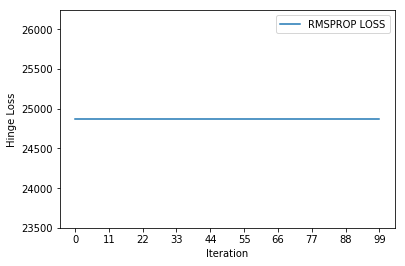

In [149]:
# 可视化实验结果
import matplotlib.pyplot as plt
#figure1,=plt.plot(ranges, loss_nag)
figure2,=plt.plot(ranges, loss_rmsprop)
plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.xticks(np.linspace(0, 99, 10))
plt.legend(handles=[figure2], labels=['RMSPROP LOSS'], loc='best')
plt.show()